## Verifying the Moran model implementation by exploring fixation times

In [284]:
import configparser

import numpy as np
import pandas as pd
import os
import json
from collections import Counter

import allel
import re

In [285]:
from lib.core import *
from lib.diagnostics import *
from lib.sequencing import *

In [345]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

import seaborn as sns

# inline stylization
%matplotlib inline
sns.set_style('white')
sns.set_style('ticks')
#sns.set_style("ticks")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Choose a parameter file

In [287]:
param_path = "../params/param_correlation.ini"

In [317]:
savefig = True

## a. Parse Parameter Set

In [288]:
# ASSIGN SIMULATION PARAMETERS
config = configparser.ConfigParser()
config.read(param_path)
# Basic
params = {}
demography = {param: int(val) for param, val in config.items('Demography')}
transmission = {param: float(val) for param, val in config.items('Transmission')}
genome = {param: int(val) for param, val in config.items('Genome')}
evolution = {param: float(val) for param, val in config.items('Evolution')}
params.update(demography)
params.update(transmission)
params.update(genome)
params.update(evolution)
# Derived & Equilibrium
derived_params = calc_derived_params(params)
equil_params = calc_equil_params(params, derived_params)
x_h = calc_x_h(**equil_params)
x_v = calc_x_v(**equil_params)
# Options
options = {}
options['back_mutation'] = config.getboolean('Options', 'back_mutation')
options['max_samples'] = eval(config.get('Options', 'max_samples'))
options['detection_threshold'] = eval(config.get('Options', 'detection_threshold'))

In [289]:
print("Parameter Values")
print("  No. of Humans:", params['nh'])
print("  No. of Vectors:", params['nv'])
print("  No. of Parasites per Human:", params['nph'])
print("  No. of Parasites per Vector:", params['npv'])
print("  No. Sites in Parasite Genome:", params['nsnps'])
print("  Bite Rate per Vector:", params['bite_rate_per_v'])
print("  Prob. Human Infected per Bite:", params['p_inf_h'])
print("  Prob. Vector Infected per Bite:", params['p_inf_v'])
print("  Drift Rate in Humans:", params['drift_rate_h'])
print("  Drift Rate in Vectors:", params['drift_rate_v'])
print("  Mutation Rate in Humans (theta):", params['theta_h'])
print("  Mutation Rate in Vectors (theta):", params['theta_v'])
print("  Rate of Human Clearance (gamma):", params['gamma'])
print("  Rate of Vector Clearance (eta):", params['eta'])
print("  Lambda:", derived_params['lmbda'])
print("  Psi:", derived_params['psi'])
print("  Expected Human Prevalence:", x_h)
print("  Expected Vector Prevalence:", x_v)
print("    Run with back mutation?", options['back_mutation'])
print("    Limit number of samples collected to:", options['max_samples'])
print("    Set the detection threshold for mixed infections to:", options['detection_threshold'])

Parameter Values
  No. of Humans: 200
  No. of Vectors: 1000
  No. of Parasites per Human: 10
  No. of Parasites per Vector: 10
  No. Sites in Parasite Genome: 1000
  Bite Rate per Vector: 0.25
  Prob. Human Infected per Bite: 0.1
  Prob. Vector Infected per Bite: 0.1
  Drift Rate in Humans: 1.0
  Drift Rate in Vectors: 2.0
  Mutation Rate in Humans (theta): 0.0001
  Mutation Rate in Vectors (theta): 0.0001
  Rate of Human Clearance (gamma): 0.005
  Rate of Vector Clearance (eta): 0.2
  Lambda: 0.125
  Psi: 0.025
  Expected Human Prevalence: 0.6538461538461539
  Expected Vector Prevalence: 0.07555555555555556
    Run with back mutation? True
    Limit number of samples collected to: 20
    Set the detection threshold for mixed infections to: 0.05


## Expected absorption times

In the Moran model, the expected number of drift events before fixation is given by:

$$ k_i = N  \Big[ \sum_{j=1}^i \frac{N-i}{N-j} + \sum_{j=i+1}^{N-1} \frac{i}{j} \Big] $$

Holding times are exponential with a fixed rate ($d$), and so the expected time to fixation is:

$$ t_i = k_i / d $$

In [290]:
def calc_expected_absorption_time(i, N, drift_rate):
    """
    Calculate the expected absorption time in the
    Moran model witha specific starting
    allele count `i`, population size `nph`,
    and `drift_time`
    
    """
    
    a = ((N - i) / (N - np.arange(1, i + 1))).sum()
    b = (i / np.arange(i+1, N)).sum()
    k_i = N * (a + b)  # expected number of transitions
    return k_i / drift_rate    

In [291]:
# Populations
h_a = np.zeros((params['nh'], params['nph'], params['nsnps']), dtype='int8')
hh = h_a[0]  # grab first host

### At a fixed initial allele frequency

In [292]:
# Define number of experiments
n_times = 500
n_repeats = 10**3

# Store in 2D arrays | time vs. replicates
freq = np.zeros((n_times, n_repeats))

# Run
times = np.arange(n_times)
repeats = np.arange(n_repeats)

for j in repeats:
    # Reset to all clonal genomes
    hh[:] = 1
    hh[:5] = 2  # set frequency
    for i, t0 in enumerate(times):
        
        # Evolve for `1` time
        hh = evolve_host(hh=hh, ti=1,
                         drift_rate=params['drift_rate_h'], theta=0.0,
                         nsnps=params['nsnps'], back_mutation=False)

        # Final frequency
        freq[i, j] = (hh[:, 0] == 2).sum()

In [298]:
# Calculate fraction fixed
fixed = (freq == 0) | (freq == 10)
frac_fixed = fixed.sum(1)

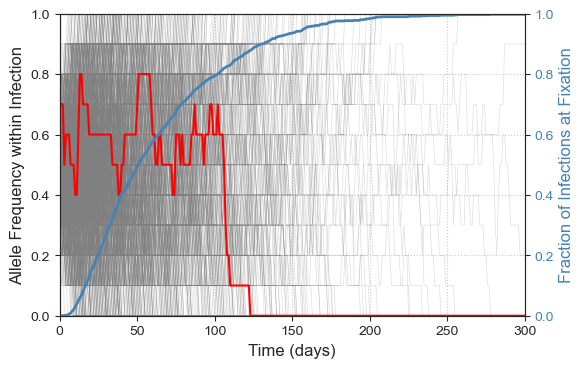

In [329]:
# Plot
fig, ax = plt.subplots(1, 1)

ax.plot(freq/10, alpha=0.25,
        color="grey", linewidth=0.5)
ax.plot(freq[:, 84]/10, color="red")

# Limits
ax.set_ylim((0, 1))
ax.set_xlim((0, 300))

# Labels
ax.set_ylabel("Allele Frequency within Infection")
ax.set_xlabel("Time (days)")

# Grid
ax.grid(linestyle="dotted")

axm = ax.twinx()
axm.plot(frac_fixed/n_repeats, color="steelblue", linewidth=2)

# Limits
axm.set_ylim((0, 1))
axm.set_xlim((0, 300))

# Labels
axm.set_ylabel("Fraction of Infections at Fixation", color="steelblue")
axm.tick_params(axis="y", labelcolor="steelblue")
axm.set_xlabel("Time (days)")

if savefig:
    fig.savefig("../figs/sec1_moran-frequencies.pdf", 
                bbox_inches="tight", 
                pad_inches=0.5)

In [320]:
# Calculate theoretical & observed time until absoprtion
t_abs = calc_expected_absorption_time(i=5, N=10, drift_rate=params["drift_rate_h"])
t_fixed = (~fixed).sum(0)

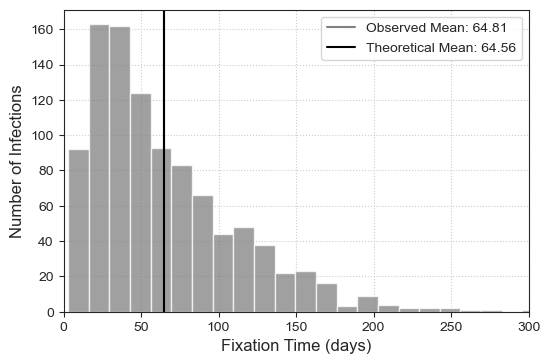

In [330]:
fig, ax = plt.subplots(1, 1)

ax.hist(t_fixed,
        color="grey",
        alpha=0.75,
        bins=25)

# Limits
ax.set_xlim((0, 300))

# Labels
ax.set_xlabel("Fixation Time (days)")
ax.set_ylabel("Number of Infections")

# Lines
ax.axvline(t_fixed.mean(), color='grey', label="Observed Mean: %.02f" % t_fixed.mean())
ax.axvline(t_abs, color='black', label="Theoretical Mean: %.02f" % t_abs)

# Grid
ax.grid(linestyle="dotted")

# Legend
ax.legend()

if savefig:
    fig.savefig("../figs/sec1_moran-fixation-times.pdf", 
                bbox_inches="tight", 
                pad_inches=0.5)

## Across a range of allele frequencies and drift rates

In [331]:
# Define number of experiments
n_rates = 3
n_init = 10
n_times = 400
n_repeats = 250

# Run
drift_rates = np.array((0.5, 1.0, 5.0))
inits = np.arange(1, n_init)
times = np.arange(n_times)
repeats = np.arange(n_repeats)

# Store in 2D arrays | time vs. replicates
freq = np.zeros((n_times, n_repeats, n_init-1, n_rates))


for x, d in enumerate(drift_rates):
    for z in inits:
        for j in repeats:
            # Reset to all clonal genomes
            hh[:] = 1
            hh[:z] = 2  # set frequency
            for i, t0 in enumerate(times):

                # Evolve for `1` time
                hh = evolve_host(hh=hh, ti=1,
                                 drift_rate=d, theta=0.0,
                                 nsnps=params['nsnps'], back_mutation=False)

                # Final frequency
                freq[i, j, (z-1), x] = (hh[:, 0] == 2).sum()

In [332]:
# Calculate fixation times
fixed = (freq == 0) | (freq == 10)
frac_fixed = fixed.sum(1)
t_fixed = (~fixed).sum(0)

# Summary stats
t_mean = t_fixed.mean(0)
t_se = t_fixed.std(0) / np.sqrt(n_repeats)

# Theoretical Expectation
t_expected = np.zeros((n_rates, n_init-1))
for x, d in enumerate(drift_rates):
    t_expected[x] = [calc_expected_absorption_time(i=i, N=10, drift_rate=d)
                     for i in inits]

In [333]:
col_map = dict(zip(drift_rates, sns.color_palette("Paired", n_rates)))

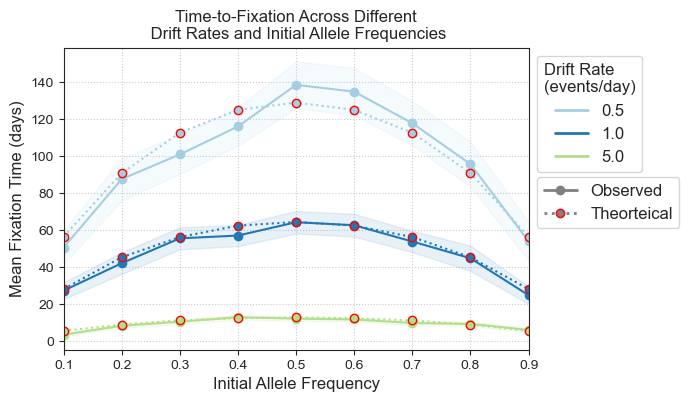

In [367]:
fig, ax = plt.subplots(1, 1)

# Observed
for x, d in enumerate(drift_rates):
    ax.plot(inits, 
            t_mean[:, x],
            linestyle="solid",
            marker="o",
            color=col_map[d],
            label="Observed")

    ax.fill_between(x=inits,
                    y1=t_mean[:, x] - 1.96 * t_se[:, x],
                    y2=t_mean[:, x] + 1.96 * t_se[:, x],
                    color=col_map[d],
                    alpha=0.1)

    # Theoretical
    ax.plot(inits, 
            t_expected[x], 
            linestyle="dotted",
            marker="o",
            color=col_map[d],
            markeredgecolor="red",
            label="Theoretical")

# Labels
ax.set_xlabel("Initial Allele Frequency")
ax.set_ylabel("Mean Fixation Time (days)")
ax.set_title("Time-to-Fixation Across Different\n Drift Rates and Initial Allele Frequencies")

# Grid
ax.grid(linestyle="dotted")

# Limits
ax.set_xlim((1, 9))

# Ticks
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, i: v / 10))

# Custom legend
col_handles = [Line2D([0], [0], color=col_map[d], linewidth=2, label=d) for d in drift_rates]
line_handle = [Line2D([0], [0], 
                      color="grey", marker="o", linewidth=2, 
                      linestyle="solid", label="Observed"),
               Line2D([0], [0], 
                      color="grey", marker="o", linewidth=2, markeredgecolor="red",
                      linestyle="dotted", label="Theoretical")]

ax.legend(handles=col_handles, bbox_to_anchor=(1, 1), title="Drift Rate\n(events/day)")
leg = Legend(ax, handles=line_handle, labels=["Observed", "Theorteical"],
             bbox_to_anchor=(1, 0.6))
ax.add_artist(leg)

if savefig:
    fig.savefig("../figs/sec1_variable-rates.pdf", 
                bbox_inches="tight", 
                pad_inches=0.5)